In [1]:
!pip install -U langgraph langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.0/951.0 kB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.0/802.0 kB 51.4 MB/s eta 0:00:00


In [2]:
%%capture
!pip install langgraph==0.3.34 langchain-openai==0.3.14 langchainhub==0.1.21 langchain==0.3.24 pygraphviz==1.14 langchain-community==0.3.23

#### 1. Tools

In [3]:
import warnings 
warnings.filterwarnings('ignore')

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import tool
import os
import json

os.environ["TAVILY_API_KEY"] = "YOUR_TAVILY_API_KEY"

# Initialize the Tavily search tool
search = TavilySearchResults()

@tool
def search_tool(query: str):
    """
    Search the web for information using Tavily API.

    :param query: The search query string
    :return: Search results related to the query
    """
    return search.invoke(query)

In [4]:
@tool
def stock_advisor(stock_symbol: str) -> str:
    """
    Provides a basic investment recommendation for a given stock symbol.

    :param stock_symbol: Ticker symbol of the stock (e.g., "AAPL")
    :return: A short recommendation string
    """
    stock_symbol = stock_symbol.upper()

    # sample advisors without live data
    sample_recommendations = {
        "AAPL": "Apple seems stable; consider holding or buying a small amount.",
        "TSLA": "Tesla is volatile; suitable for risk-tolerant investors.",
        "AMZN": "Amazon has growth potential; consider long-term investment.",
    }

    return sample_recommendations.get(stock_symbol, "No recommendation available for this stock.")


#### 2. Prompt

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage,SystemMessage

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful AI assistant that thinks step-by-step and uses tools when needed.

When responding to queries:
1. First, think about what information you need
2. Use available tools if you need current data or specific capabilities  
3. Provide clear, helpful responses based on your reasoning and any tool results

Always explain your thinking process to help users understand your approach.
"""),
    MessagesPlaceholder(variable_name="scratch_pad")
])

#### 3. Initializing the AI Model

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

model = ChatOpenAI(model="gpt-4o-mini")

#### 4. Creating the Tool Registry

In [7]:
tools=[search_tool,stock_advisor]

tools_by_name={ tool.name:tool for tool in tools}

In [17]:
model_react=chat_prompt|model.bind_tools(tools)

#### 5. State

In [18]:
from typing import (Annotated,Sequence,TypedDict)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### 6. Nodes

In [10]:
def tool_node(state: AgentState):
    """Execute all tool calls from the last message in the state."""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

In [11]:
def call_model(state: AgentState):
    """Invoke the model with the current conversation state."""
    response = model_react.invoke({"scratch_pad": state["messages"]})
    return {"messages": [response]}

#### 7. Condition

In [12]:
def should_continue(state: AgentState):
    """Determine whether to continue with tool use or end the conversation."""
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

#### 8. 

In [13]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Add edges between nodes
workflow.add_edge("tools", "agent")  # After tools, always go back to agent

# Add conditional logic
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",  # If tools needed, go to tools node
        "end": END,          # If done, end the conversation
    },
)

# Set entry point
workflow.set_entry_point("agent")

# Compile the graph
graph = workflow.compile()

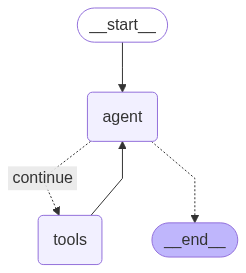

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
def print_stream(stream):
    """Helper function for formatting the stream nicely."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [HumanMessage(content="Can you check the latest news about Tesla stock and then tell me if it's a good investment?")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Can you check the latest news about Tesla stock and then tell me if it's a good investment?
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_htc2f0kukBsKb1xWiluu7PjW)
 Call ID: call_htc2f0kukBsKb1xWiluu7PjW
  Args:
    query: latest news Tesla stock
  stock_advisor (call_5sPzWzSZrkRo9uYgd6HcmhzT)
 Call ID: call_5sPzWzSZrkRo9uYgd6HcmhzT
  Args:
    stock_symbol: TSLA
================================= Tool Message =================================
Name: stock_advisor

"Tesla is volatile; suitable for risk-tolerant investors."
================================== Ai Message ==================================

Here's the latest news on Tesla (TSLA) stock along with a brief investment recommendation.

### Latest News on Tesla Stock
1. **Energy Storage Focus**: Tesla has announced the launch of the Megapack 3 and Megablock battery storage systems, wh